<a href="https://colab.research.google.com/github/AbdusSattar2025/Assignments/blob/main/CIC_3rd_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rdkit
!pip install pyscf

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import AllChem, PandasTools
from rdkit.Chem import Draw
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import Descriptors
from rdkit import DataStructs
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load the QM9 dataset (subset of 5K molecules)
# df_subset = df_qm9.sample(n=5000, random_state=42).reset_index(drop=True)
# Assuming the dataset is in a CSV format with a column 'SMILES' containing the SMILES of molecules
df = pd.read_csv('/content/qm9_processed.csv')

# Selecting 5000 molecules from the dataset
df = df.head(5000)
smiles = df['smiles_canonical']  # SMILES strings of molecules


# Extract SMILES column
smiles = df['smiles_canonical']
df.head()





,mol_id,smiles_canonical,A,B,C,mu,alpha,homo,lumo,gap,r2,zpve,U0,U,H,G,Cv
0,gdb_1,C,157.71180,157.709970,157.706990,0.0000,13.21,-0.3877,0.1171,0.5048,35.3641,0.044749,-40.478930,-40.476062,-40.475117,-40.498597,6.469
1,gdb_2,N,293.60975,293.541110,191.393970,1.6256,9.46,-0.2570,0.0829,0.3399,26.1563,0.034358,-56.525887,-56.523026,-56.522082,-56.544961,6.316
2,gdb_3,O,799.58812,437.903860,282.945450,1.8511,6.31,-0.2928,0.0687,0.3615,19.0002,0.021375,-76.404702,-76.401867,-76.400922,-76.422349,6.002
3,gdb_4,C#C,0.00000,35.610036,35.610036,0.0000,16.28,-0.2845,0.0506,0.3351,59.5248,0.026841,-77.308427,-77.305527,-77.304583,-77.327429,8.574
4,gdb_5,C#N,0.00000,44.593883,44.593883,2.8937,12.99,-0.3604,0.0191,0.3796,48.7476,0.016601,-93.411888,-93.409370,-93.408425,-93.431246,6.278


In [ ]:
print(df.shape)

(5000, 17)


In [ ]:
# Convert SMILES to RDKit molecule objects and then to canonical SMILES
mols = [Chem.MolFromSmiles(s) for s in df['smiles_canonical']]
# Filter out any invalid SMILES that could not be converted to molecule objects
valid_mols = [mol for mol in mols if mol is not None]
Canon_SMILES = [Chem.MolToSmiles(mol) for mol in valid_mols]

print(f"Number of canonicalized SMILES: {len(Canon_SMILES)}")

Number of canonicalized SMILES: 5000


In [ ]:
def RDkit_descriptors(smiles):
    mols = [Chem.MolFromSmiles(i) for i in smiles]
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
    desc_names = calc.GetDescriptorNames()

    Mol_descriptors =[]
    for mol in mols:
        # add hydrogens to molecules
        mol=Chem.AddHs(mol)
        # Calculate all 200 descriptors for each molecule
        descriptors = calc.CalcDescriptors(mol)
        Mol_descriptors.append(descriptors)
    return Mol_descriptors,desc_names

# Function call
Mol_descriptors,desc_names = RDkit_descriptors(df['SMILES'])

df_with_200_descriptors = pd.DataFrame(Mol_descriptors,columns=desc_names)
df_with_200_descriptors

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,5.937500,5.937500,2.500000,-2.500000,0.359785,64.00,16.043,12.011,16.031300,8,...,0,0,0,0,0,0,0,0,0,0
1,5.750000,5.750000,0.250000,-0.250000,0.397555,39.00,17.031,14.007,17.026549,8,...,0,0,0,0,0,0,0,0,0,0
2,5.375000,5.375000,2.750000,2.750000,0.327748,20.00,18.015,15.999,18.010565,8,...,0,0,0,0,0,0,0,0,0,0
3,5.902778,5.902778,1.597222,1.597222,0.332926,8.00,26.038,24.022,26.015650,10,...,0,0,0,1,0,0,0,0,0,0
4,6.986111,6.986111,1.000000,1.000000,0.369797,4.50,27.026,26.018,27.010899,10,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,11.192523,11.192523,0.041412,-2.780093,0.513633,21.50,110.116,104.068,110.048013,42,...,0,0,0,0,0,0,0,0,0,0
4996,7.216968,7.216968,0.552315,-2.623843,0.527132,24.25,110.116,104.068,110.048013,42,...,0,0,0,0,0,0,0,0,0,0
4997,10.900856,10.900856,0.734954,-2.723843,0.484580,19.75,111.100,106.060,111.032028,42,...,0,0,0,0,0,0,0,0,0,0
4998,11.138079,11.138079,0.038727,-2.760532,0.513633,21.50,110.116,104.068,110.048013,42,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Check for descriptors with zero variance
selector = VarianceThreshold(threshold=0)
selector.fit(df_with_200_descriptors)
zero_variance_descriptors = df_with_200_descriptors.columns[~selector.get_support()]

print(f"Descriptors with zero variance: {list(zero_variance_descriptors)}")

# Remove descriptors with zero variance
df_filtered = df_with_200_descriptors.drop(columns=zero_variance_descriptors)

print(f"Shape of dataframe after removing zero variance descriptors: {df_filtered.shape}")

Descriptors with zero variance: ['NumRadicalElectrons', 'SMR_VSA8', 'SlogP_VSA12', 'SlogP_VSA8', 'SlogP_VSA9', 'EState_VSA11', 'VSA_EState10', 'fr_Al_OH_noTert', 'fr_Ar_COO', 'fr_C_S', 'fr_N_O', 'fr_SH', 'fr_azide', 'fr_azo', 'fr_barbitur', 'fr_benzodiazepine', 'fr_diazo', 'fr_dihydropyridine', 'fr_hdrzine', 'fr_hdrzone', 'fr_isocyan', 'fr_isothiocyan', 'fr_nitro', 'fr_nitro_arom', 'fr_nitro_arom_nonortho', 'fr_nitroso', 'fr_phos_acid', 'fr_phos_ester', 'fr_prisulfonamd', 'fr_sulfide', 'fr_sulfonamd', 'fr_sulfone', 'fr_thiazole', 'fr_thiocyan', 'fr_thiophene', 'fr_unbrch_alkane']
Shape of dataframe after removing zero variance descriptors: (5000, 181)


In [ ]:
# Find highly correlated features (absolute correlation > 0.9)
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
highly_correlated_pairs = [(column, row) for column in upper.columns for row in upper.index if abs(upper.loc[row, column]) > 0.9]

print("Highly correlated descriptor pairs (absolute correlation > 0.9):")
for pair in highly_correlated_pairs:
    print(pair)

Highly correlated descriptor pairs (absolute correlation > 0.9):
('MaxEStateIndex', 'MaxAbsEStateIndex')
('HeavyAtomMolWt', 'MolWt')
('ExactMolWt', 'MolWt')
('ExactMolWt', 'HeavyAtomMolWt')
('NumValenceElectrons', 'MolWt')
('NumValenceElectrons', 'ExactMolWt')
('MaxAbsPartialCharge', 'MinPartialCharge')
('MinAbsPartialCharge', 'MaxPartialCharge')
('FpDensityMorgan2', 'FpDensityMorgan1')
('FpDensityMorgan3', 'FpDensityMorgan2')
('BCUT2D_LOGPHI', 'BCUT2D_CHGHI')
('Chi0n', 'Chi0')
('Chi0v', 'MolWt')
('Chi0v', 'ExactMolWt')
('Chi1', 'Chi0')
('Chi1', 'Chi0n')
('Chi1n', 'Chi0')
('Chi1n', 'Chi0n')
('Chi1n', 'Chi1')
('Chi2n', 'Chi1v')
('Chi2v', 'Chi1v')
('Chi2v', 'Chi2n')
('Chi3n', 'Chi2n')
('Chi3n', 'Chi2v')
('Chi3v', 'Chi2n')
('Chi3v', 'Chi2v')
('Chi3v', 'Chi3n')
('Chi4n', 'Chi2n')
('Chi4n', 'Chi2v')
('Chi4n', 'Chi3n')
('Chi4n', 'Chi3v')
('Chi4v', 'Chi2n')
('Chi4v', 'Chi2v')
('Chi4v', 'Chi3n')
('Chi4v', 'Chi3v')
('Chi4v', 'Chi4n')
('LabuteASA', 'Chi1')
('SlogP_VSA6', 'SMR_VSA7')
('VSA_EState

In [ ]:
# Standardize the data before applying PCA and t-SNE
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_filtered)

# Apply PCA
pca = PCA(n_components=2) # Reduce to 2 components for visualization
pca_components = pca.fit_transform(df_scaled)
df_pca = pd.DataFrame(data = pca_components, columns = ['PC1', 'PC2'])

print("PCA results (first 50 rows):")
display(df_pca.head(50))

PCA results (first 50 rows):


,PC1,PC2
0,-5.917657,-17.454716
1,-10.452246,-12.174947
2,-11.206903,-12.998393
3,-7.384994,-14.866589
4,-8.941454,-14.432903
5,-7.774028,-15.210181
6,-1.700326,-14.774696
7,-5.973709,-13.335091
8,-4.221408,-13.395252
9,-5.083291,-12.865112


In [ ]:
# Apply t-SNE
# Note: t-SNE is computationally intensive and may take some time for 5000 samples
# It's often recommended to first reduce dimensionality with PCA before applying t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300) # Reduce to 2 components
tsne_components = tsne.fit_transform(df_scaled)
df_tsne = pd.DataFrame(data = tsne_components, columns = ['TSNE1', 'TSNE2'])

print("t-SNE results (first 50 rows):")
display(df_tsne.head(50))

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


t-SNE results (first 50 rows):


,TSNE1,TSNE2
0,-0.946493,0.671039
1,-1.171154,-0.168394
2,-1.172794,-0.175809
3,-0.924020,1.198035
4,-1.121672,0.445607
5,-1.045593,0.314099
6,-0.830291,0.801320
7,-0.557608,0.814100
8,-0.840101,1.574710
9,-1.345481,0.246039


In [ ]:
print(df.columns)

Index(['mol_id', 'smiles_canonical', 'A', 'B', 'C', 'mu', 'alpha', 'homo',
       'lumo', 'gap', 'r2', 'zpve', 'U0', 'U', 'H', 'G', 'Cv', 'SMILES'],
      dtype='object')


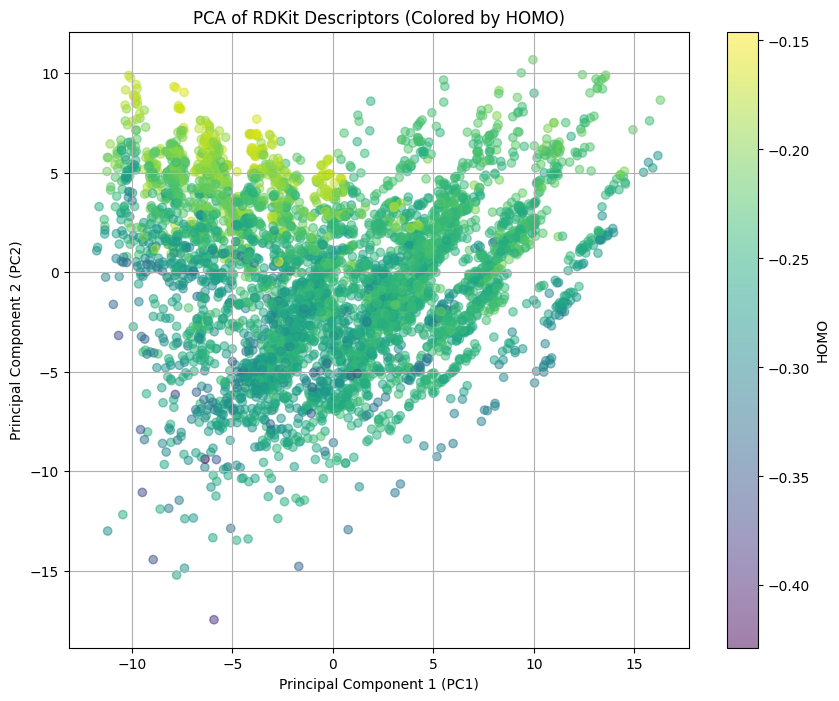

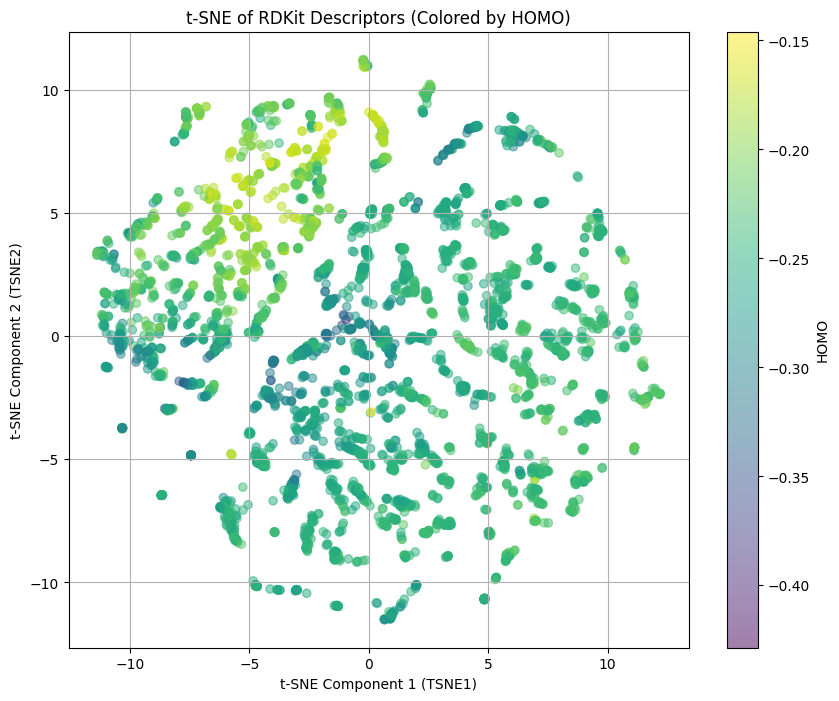

In [ ]:
# Visualize PCA results colored by 'homo'
plt.figure(figsize=(10, 8))
scatter_pca = plt.scatter(df_pca['PC1'], df_pca['PC2'], c=df['homo'], cmap='viridis', alpha=0.5)
plt.title('PCA of RDKit Descriptors (Colored by HOMO)')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.colorbar(scatter_pca, label='HOMO')
plt.grid(True)
plt.show()

# Visualize t-SNE results colored by 'homo'
plt.figure(figsize=(10, 8))
scatter_tsne = plt.scatter(df_tsne['TSNE1'], df_tsne['TSNE2'], c=df['homo'], cmap='viridis', alpha=0.5)
plt.title('t-SNE of RDKit Descriptors (Colored by HOMO)')
plt.xlabel('t-SNE Component 1 (TSNE1)')
plt.ylabel('t-SNE Component 2 (TSNE2)')
plt.colorbar(scatter_tsne, label='HOMO')
plt.grid(True)
plt.show()

# Task
Perform clustering on the `df_pca` data and visualize the results on the PCA plot.

In [ ]:
from sklearn.cluster import KMeans

# Instantiate KMeans with a chosen number of clusters
# Let's choose 5 clusters for demonstration purposes
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)

# Fit KMeans to the PCA-transformed data
kmeans.fit(df_pca)

# Get the cluster labels and add them to the df_pca DataFrame
df_pca['cluster_label'] = kmeans.labels_

print("PCA results with cluster labels (first 50 rows):")
display(df_pca.head(50))

PCA results with cluster labels (first 50 rows):


,PC1,PC2,cluster_label
0,-5.917657,-17.454716,2
1,-10.452246,-12.174947,2
2,-11.206903,-12.998393,2
3,-7.384994,-14.866589,2
4,-8.941454,-14.432903,2
5,-7.774028,-15.210181,2
6,-1.700326,-14.774696,2
7,-5.973709,-13.335091,2
8,-4.221408,-13.395252,2
9,-5.083291,-12.865112,2


### Visualize the clustering results



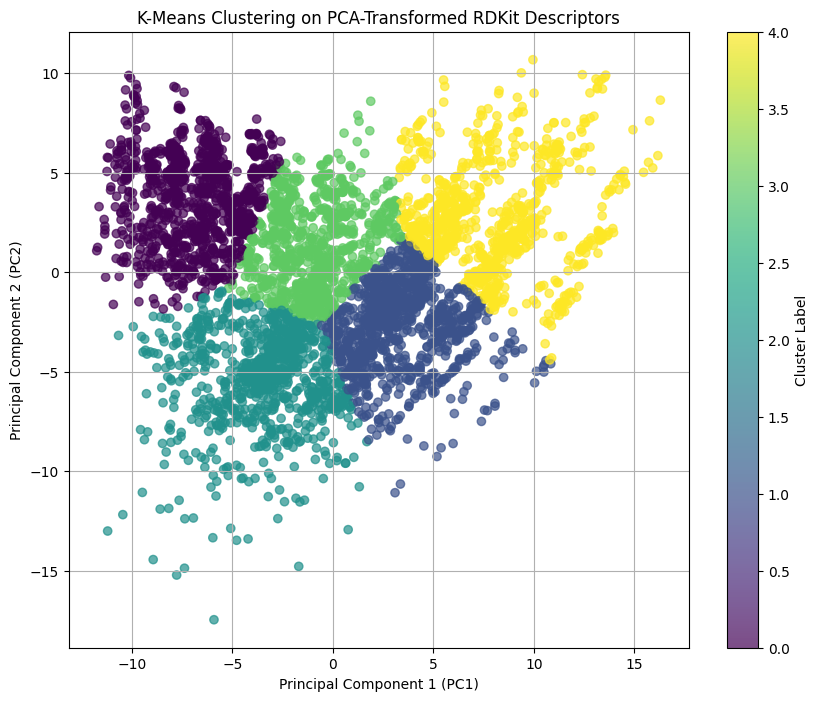

In [ ]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(df_pca['PC1'], df_pca['PC2'], c=df_pca['cluster_label'], cmap='viridis', alpha=0.7)
plt.title('K-Means Clustering on PCA-Transformed RDKit Descriptors')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.colorbar(scatter, label='Cluster Label')
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Calculate the silhouette score for PCA clustering
silhouette_avg_pca = silhouette_score(df_pca[['PC1', 'PC2']], df_pca['cluster_label'])
print(f"Silhouette Score for PCA clustering: {silhouette_avg_pca}")

# Calculate the Davies-Bouldin index for PCA clustering
db_index_pca = davies_bouldin_score(df_pca[['PC1', 'PC2']], df_pca['cluster_label'])
print(f"Davies-Bouldin Index for PCA clustering: {db_index_pca}")

Silhouette Score for PCA clustering: 0.37670834714742785
Davies-Bouldin Index for PCA clustering: 0.8435539249235591


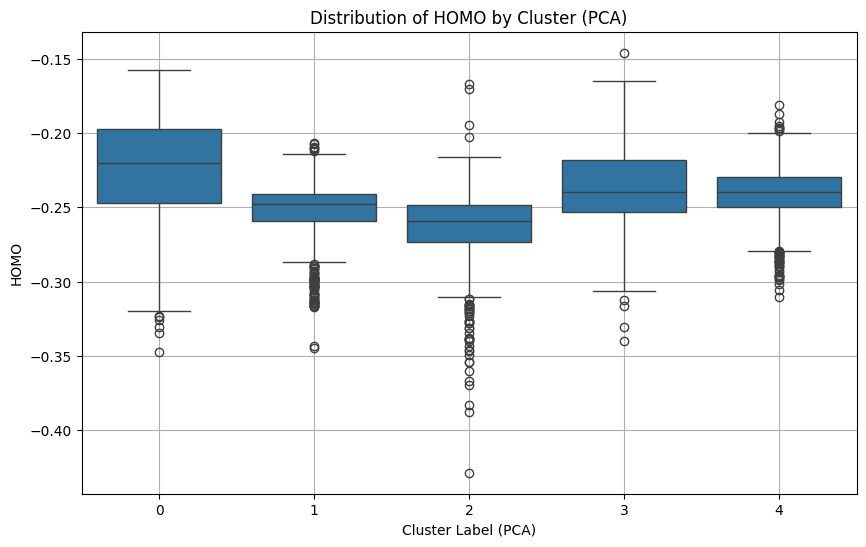

In [ ]:
# Merge df_pca with the original df to get 'homo' values along with cluster labels
df_pca_homo = pd.merge(df[['homo']], df_pca[['cluster_label']], left_index=True, right_index=True)

# Visualize the distribution of 'homo' for each cluster using a box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='cluster_label', y='homo', data=df_pca_homo)
plt.title('Distribution of HOMO by Cluster (PCA)')
plt.xlabel('Cluster Label (PCA)')
plt.ylabel('HOMO')
plt.grid(True)
plt.show()

# Task
Apply clustering to df_tsne and visualize on t-SNE plot

In [ ]:
from sklearn.cluster import KMeans

# Instantiate KMeans with a chosen number of clusters
# Let's choose 5 clusters for consistency with the PCA clustering
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)

# Fit KMeans to the t-SNE transformed data
kmeans.fit(df_tsne)

# Get the cluster labels and add them to the df_tsne DataFrame
df_tsne['cluster_label'] = kmeans.labels_

print("t-SNE results with cluster labels (first 50 rows):")
display(df_tsne.head(50))

t-SNE results with cluster labels (first 50 rows):


,TSNE1,TSNE2,cluster_label
0,-0.946493,0.671039,2
1,-1.171154,-0.168394,0
2,-1.172794,-0.175809,0
3,-0.924020,1.198035,2
4,-1.121672,0.445607,0
5,-1.045593,0.314099,0
6,-0.830291,0.801320,2
7,-0.557608,0.814100,2
8,-0.840101,1.574710,2
9,-1.345481,0.246039,0


## Visualize the clustering results




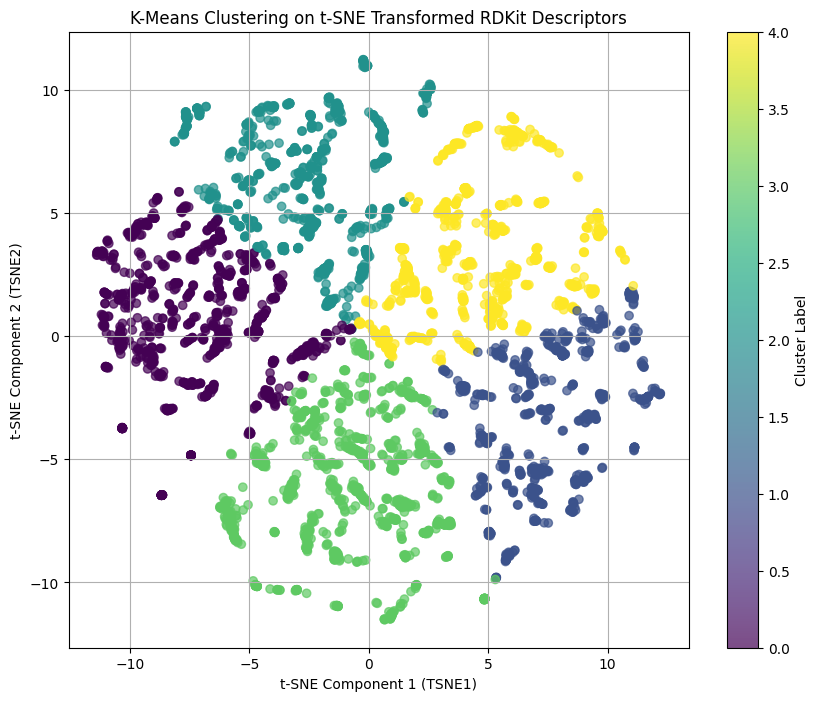

In [ ]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(df_tsne['TSNE1'], df_tsne['TSNE2'], c=df_tsne['cluster_label'], cmap='viridis', alpha=0.7)
plt.title('K-Means Clustering on t-SNE Transformed RDKit Descriptors')
plt.xlabel('t-SNE Component 1 (TSNE1)')
plt.ylabel('t-SNE Component 2 (TSNE2)')
plt.colorbar(scatter, label='Cluster Label')
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Calculate the silhouette score
silhouette_avg = silhouette_score(df_tsne[['TSNE1', 'TSNE2']], df_tsne['cluster_label'])
print(f"Silhouette Score: {silhouette_avg}")

# Calculate the Davies-Bouldin index
db_index = davies_bouldin_score(df_tsne[['TSNE1', 'TSNE2']], df_tsne['cluster_label'])
print(f"Davies-Bouldin Index: {db_index}")

Silhouette Score: 0.35548439621925354
Davies-Bouldin Index: 0.8825606690886723


## Analyze the clusters



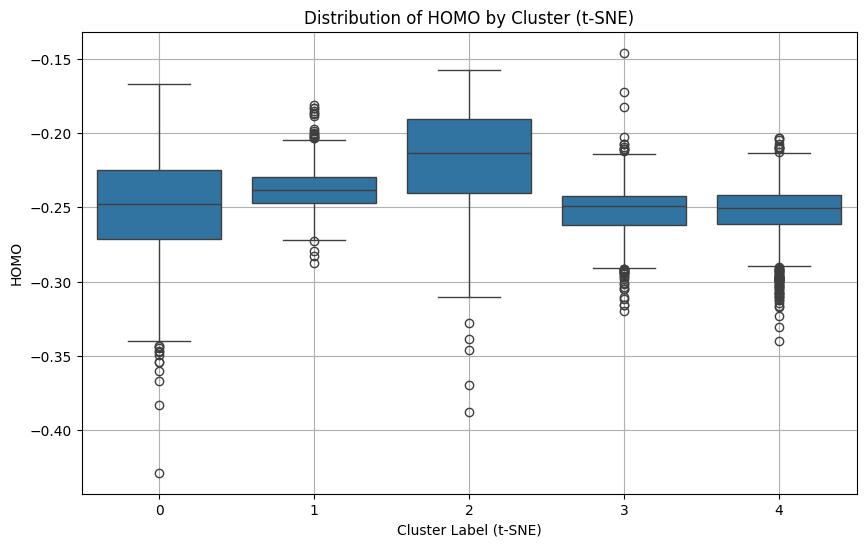

In [ ]:
# Merge df_tsne with the original df to get 'homo' values along with cluster labels
df_tsne_homo = pd.merge(df[['homo']], df_tsne[['cluster_label']], left_index=True, right_index=True)

# Visualize the distribution of 'homo' for each cluster using a box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='cluster_label', y='homo', data=df_tsne_homo)
plt.title('Distribution of HOMO by Cluster (t-SNE)')
plt.xlabel('Cluster Label (t-SNE)')
plt.ylabel('HOMO')
plt.grid(True)
plt.show()

In [ ]:
from scipy import stats

# Function to perform ANOVA for each descriptor
def perform_anova(df_data, cluster_labels, descriptors):
    anova_results = {}
    for descriptor in descriptors:
        if descriptor in df_data.columns:
            # Create a list of data arrays for each cluster
            cluster_data = [df_data[descriptor][cluster_labels == label] for label in sorted(cluster_labels.unique())]
            # Perform ANOVA test
            fvalue, pvalue = stats.f_oneway(*cluster_data)
            anova_results[descriptor] = pvalue
        else:
            anova_results[descriptor] = None # Descriptor not found

    # Sort descriptors by p-value (lower p-value means better separation)
    sorted_anova_results = sorted(anova_results.items(), key=lambda item: item[1] if item[1] is not None else float('inf'))

    return sorted_anova_results

# Perform ANOVA for PCA clusters
print("ANOVA results for PCA clusters (top 20 descriptors):")
anova_pca_results = perform_anova(df_filtered.drop(columns=['cluster_label']), df_pca['cluster_label'], df_filtered.drop(columns=['cluster_label']).columns)
for descriptor, pvalue in anova_pca_results[:20]:
    print(f"  {descriptor}: p-value = {pvalue:.4f}")

print("\nANOVA results for t-SNE clusters (top 20 descriptors):")
# Perform ANOVA for t-SNE clusters
anova_tsne_results = perform_anova(df_filtered.drop(columns=['cluster_label']), df_tsne['cluster_label'], df_filtered.drop(columns=['cluster_label']).columns)
for descriptor, pvalue in anova_tsne_results[:20]:
    print(f"  {descriptor}: p-value = {pvalue:.4f}")

ANOVA results for PCA clusters (top 20 descriptors):
  MinAbsEStateIndex: p-value = 0.0000
  MinEStateIndex: p-value = 0.0000
  SPS: p-value = 0.0000
  HeavyAtomMolWt: p-value = 0.0000
  MaxPartialCharge: p-value = 0.0000
  MinAbsPartialCharge: p-value = 0.0000
  BCUT2D_MWLOW: p-value = 0.0000
  BCUT2D_CHGHI: p-value = 0.0000
  BCUT2D_CHGLO: p-value = 0.0000
  BCUT2D_LOGPHI: p-value = 0.0000
  AvgIpc: p-value = 0.0000
  BalabanJ: p-value = 0.0000
  BertzCT: p-value = 0.0000
  Chi0: p-value = 0.0000
  Chi0n: p-value = 0.0000
  Chi0v: p-value = 0.0000
  Chi1: p-value = 0.0000
  Chi1n: p-value = 0.0000
  Chi1v: p-value = 0.0000
  Chi2n: p-value = 0.0000

ANOVA results for t-SNE clusters (top 20 descriptors):
  MaxAbsEStateIndex: p-value = 0.0000
  MaxEStateIndex: p-value = 0.0000
  MinAbsEStateIndex: p-value = 0.0000
  SPS: p-value = 0.0000
  BCUT2D_MWLOW: p-value = 0.0000
  BCUT2D_CHGHI: p-value = 0.0000
  BCUT2D_CHGLO: p-value = 0.0000
  BCUT2D_LOGPHI: p-value = 0.0000
  BCUT2D_LOGPLOW:

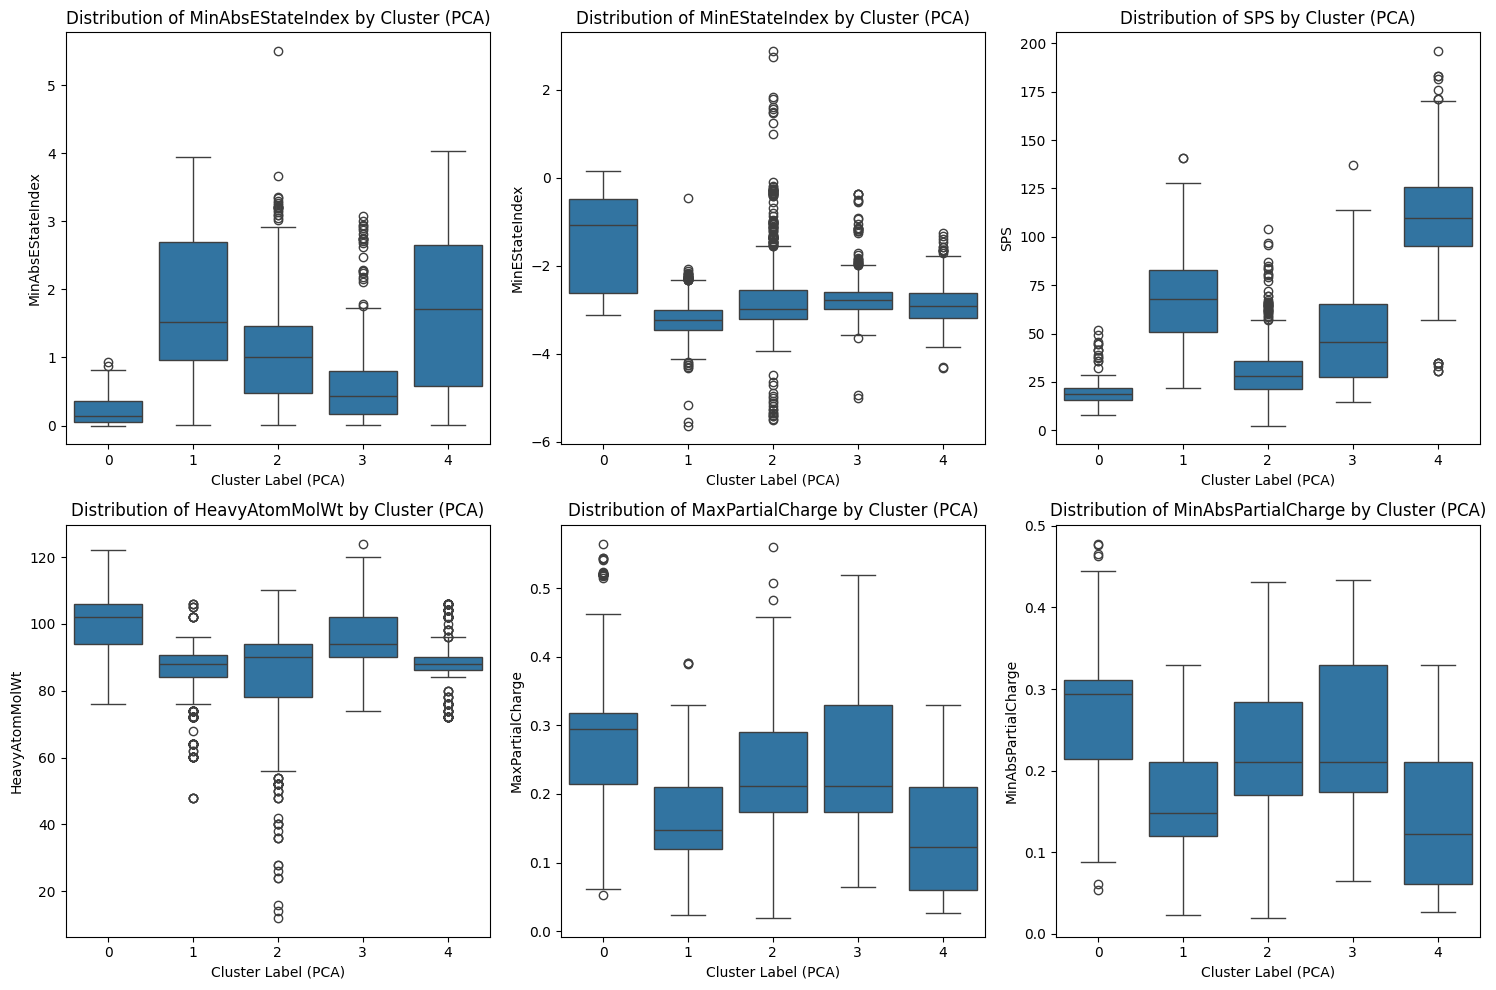

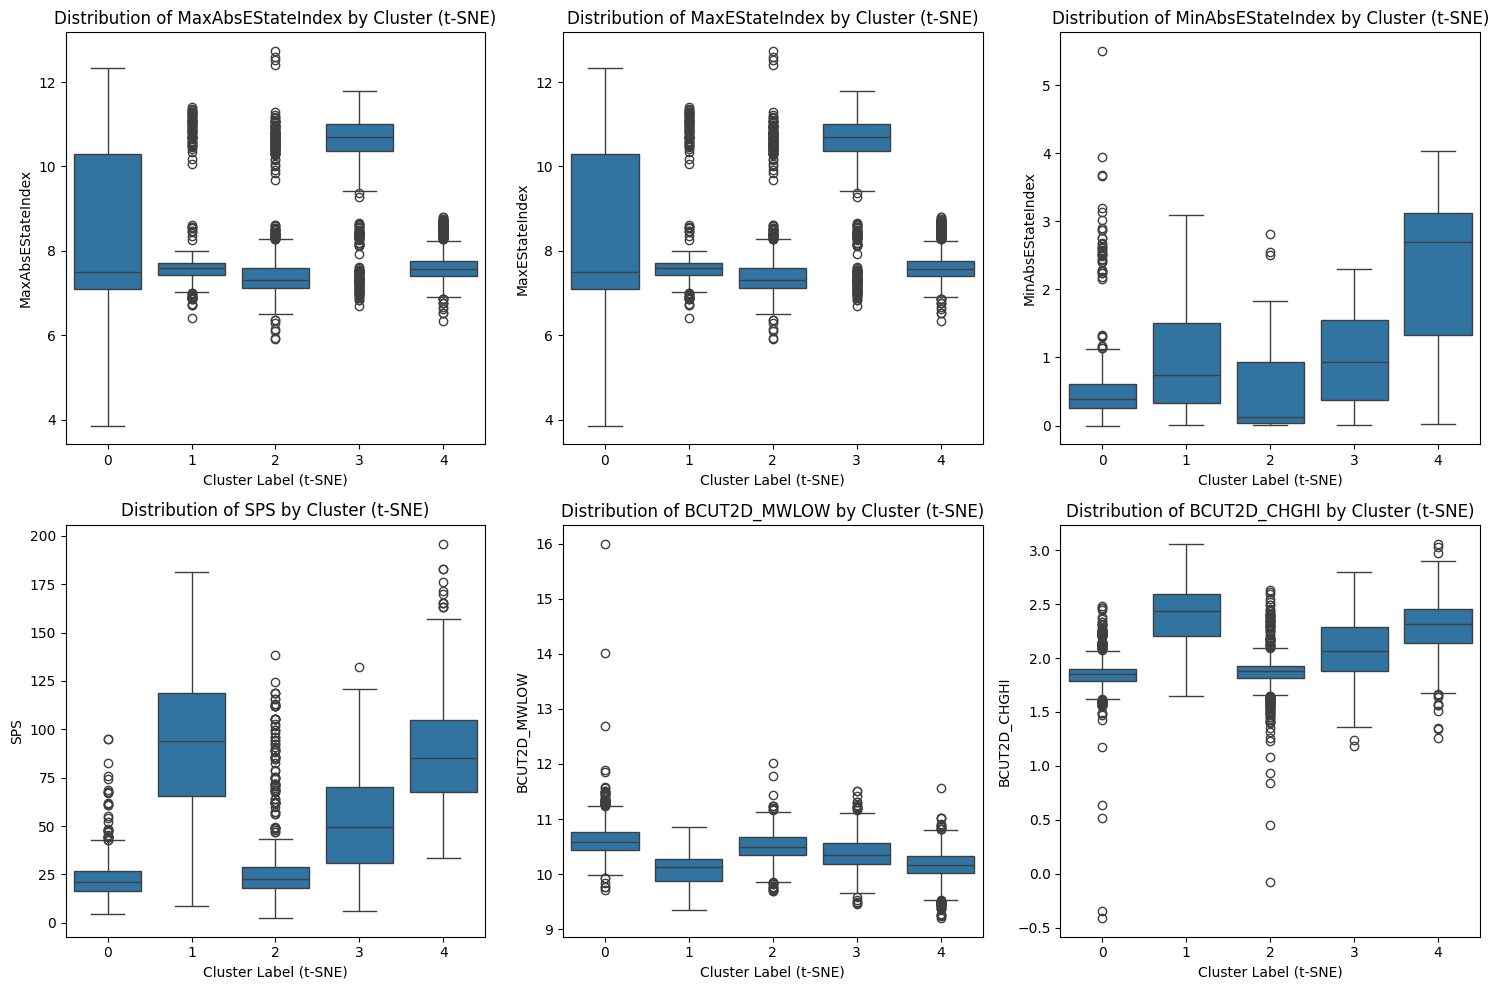

In [ ]:
# Select the top N descriptors from ANOVA results for visualization
top_n = 6 # You can adjust this number

top_pca_descriptors = [desc for desc, pval in anova_pca_results[:top_n]]
top_tsne_descriptors = [desc for desc, pval in anova_tsne_results[:top_n]]

# Add cluster labels from df_pca to df_filtered (if not already there)
if 'cluster_label_pca' not in df_filtered.columns:
    df_filtered['cluster_label_pca'] = df_pca['cluster_label']

# Plot distributions for top PCA descriptors
plt.figure(figsize=(15, 10))
for i, descriptor in enumerate(top_pca_descriptors):
    plt.subplot(2, 3, i + 1) # Arrange plots in a 2x3 grid
    sns.boxplot(x='cluster_label_pca', y=descriptor, data=df_filtered)
    plt.title(f'Distribution of {descriptor} by Cluster (PCA)')
    plt.xlabel('Cluster Label (PCA)')
    plt.ylabel(descriptor)

plt.tight_layout()
plt.show()

# Add cluster labels from df_tsne to df_filtered (if not already there)
if 'cluster_label_tsne' not in df_filtered.columns:
    df_filtered['cluster_label_tsne'] = df_tsne['cluster_label']

# Plot distributions for top t-SNE descriptors
plt.figure(figsize=(15, 10))
for i, descriptor in enumerate(top_tsne_descriptors):
    plt.subplot(2, 3, i + 1) # Arrange plots in a 2x3 grid
    sns.boxplot(x='cluster_label_tsne', y=descriptor, data=df_filtered)
    plt.title(f'Distribution of {descriptor} by Cluster (t-SNE)')
    plt.xlabel('Cluster Label (t-SNE)')
    plt.ylabel(descriptor)

plt.tight_layout()
plt.show()

In [ ]:
# Merge df_pca with the original df to get molecular properties along with cluster labels
df_clustered_pca = pd.merge(df, df_pca, left_index=True, right_index=True)

# Analyze the distribution of key molecular properties for each cluster
molecular_properties = ['mu', 'alpha', 'homo', 'lumo', 'gap', 'Cv']

print("Descriptive statistics of molecular properties for each cluster (PCA):")
display(df_clustered_pca.groupby('cluster_label')[molecular_properties].describe())

Descriptive statistics of molecular properties for each cluster (PCA):


mu                                                       \
                count      mean       std  min       25%     50%       75%   
cluster_label                                                                
0              1080.0  3.155986  1.651965  0.0  1.907775  2.9644  4.189050   
1              1144.0  2.218033  1.252643  0.0  1.275100  2.0802  3.144075   
2               904.0  3.011017  1.577311  0.0  1.910050  2.9962  3.954975   
3               907.0  2.625491  1.410420  0.0  1.497000  2.4315  3.615100   
4               965.0  1.580524  0.950207  0.0  1.089400  1.5749  1.929400   

                         alpha             ...      gap              Cv  \
                   max   count       mean  ...      75%     max   count   
cluster_label                              ...                            
0               8.9868  1080.0  57.926565  ...  0.23335  0.2842  1080.0   
1               6.1718  1144.0  61.057281  ...  0.32145  0.4306  1144.0   
2              14.8809   904.0  51.826095  ...  0.28210  0.6221   904.0   
3               8.7692   907.0  61.828004  ...  0.26035  0.3642   907.0   
4               5.5166   965.0  62.690363  ...  0.32870  0.3958   965.0   

                                                                         \
                    mean       std     min       25%      50%       75%   
cluster_label                                                             
0              23.786994  3.747373  13.622  21.13675  24.0655  26.20875   
1              26.701267  3.797129  14.648  24.45775  26.9045  29.23125   
2              23.587392  4.608757   6.002  21.17750  24.9125  27.05675   
3              25.739838  3.675483  16.529  22.94450  25.3760  28.32900   
4              25.110589  3.613517  15.634  22.73600  24.6480  27.48300   

                       
                  max  
cluster_label          
0              34.926  
1              37.732  
2              31.741  
3              38.018  
4              36.540  

[5 rows x 48 columns]

In [ ]:
# Merge df_tsne with the original df to get molecular properties along with cluster labels
df_clustered = pd.merge(df, df_tsne, left_index=True, right_index=True)

# Analyze the distribution of key molecular properties for each cluster
molecular_properties = ['mu', 'alpha', 'homo', 'lumo', 'gap', 'Cv']

print("Descriptive statistics of molecular properties for each cluster:")
display(df_clustered.groupby('cluster_label')[molecular_properties].describe())

Descriptive statistics of molecular properties for each cluster:


mu                                                        \
                count      mean       std     min      25%     50%      75%   
cluster_label                                                                 
0              1051.0  3.291556  1.614149  0.0000  2.16820  3.2284  4.22945   
1               792.0  1.894622  0.934916  0.0000  1.28710  1.7433  2.33915   
2               945.0  2.386825  1.683880  0.0000  1.18990  1.9275  3.44460   
3              1191.0  3.088916  1.191630  0.0005  2.33155  3.0125  3.81060   
4              1021.0  1.645413  1.157270  0.0000  1.04480  1.4434  1.94330   

                         alpha             ...       gap              Cv  \
                   max   count       mean  ...       75%     max   count   
cluster_label                              ...                             
0              14.8809  1051.0  55.967735  ...  0.256250  0.6221  1051.0   
1               5.2991   792.0  61.395265  ...  0.309925  0.3559   792.0   
2               8.9868   945.0  63.060952  ...  0.248400  0.5048   945.0   
3               8.9283  1191.0  55.529353  ...  0.269850  0.3336  1191.0   
4               6.6794  1021.0  61.371214  ...  0.337700  0.4179  1021.0   

                                                                               
                    mean       std     min      25%     50%       75%     max  
cluster_label                                                                  
0              22.994132  4.093200   6.002  20.0780  23.551  25.79350  31.282  
1              25.346590  4.191206  14.648  22.7415  24.776  28.04075  38.018  
2              26.160666  3.773054   6.469  24.0680  26.433  28.88900  33.532  
3              24.611168  3.415521  10.890  22.2690  24.699  27.01800  32.977  
4              26.309398  4.023972   9.176  23.8330  26.542  28.87900  36.540  

[5 rows x 48 columns]

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# Prepare data for regression on PCA features
X_pca = df_pca[['PC1', 'PC2']]
y_homo = df['homo']

# Split data into training and testing sets
X_train_pca, X_test_pca, y_train_homo, y_test_homo = train_test_split(X_pca, y_homo, test_size=0.2, random_state=42)

# Train a Linear Regression model on PCA features
model_pca = LinearRegression()
model_pca.fit(X_train_pca, y_train_homo)

# Predict on the test set and calculate MAE
y_pred_pca = model_pca.predict(X_test_pca)
mae_homo = mean_absolute_error(y_test_homo, y_pred_pca)

# Prepare data for regression on t-SNE features
X_tsne = df_tsne[['TSNE1', 'TSNE2']]

# Split data into training and testing sets (using the same split as PCA for fair comparison)
X_train_tsne, X_test_tsne, y_train_homo_tsne, y_test_homo_tsne = train_test_split(X_tsne, y_homo, test_size=0.2, random_state=42)


# Train a Linear Regression model on t-SNE features
model_tsne = LinearRegression()
model_tsne.fit(X_train_tsne, y_train_homo_tsne)

# Predict on the test set and calculate MAE
y_pred_tsne = model_tsne.predict(X_test_tsne)
mae_homo_tsne = mean_absolute_error(y_test_homo_tsne, y_pred_tsne)

print(f"MAE (PCA features) for HOMO prediction: {mae_homo:.4f}")
print(f"MAE (t-SNE features) for HOMO prediction: {mae_homo_tsne:.4f}")

MAE (PCA features) for HOMO prediction: 0.0184
MAE (t-SNE features) for HOMO prediction: 0.0214


##Summary:

While both PCA and t-SNE reduce the dimensionality of the RDKit descriptors and reveal some structure in the data, they do so differently. PCA, a linear method, provides a general overview and is slightly better for linear prediction of HOMO in this case. t-SNE, a non-linear method, appears to be more effective at identifying distinct clusters that visually separate well and show clearer differences in the distribution of the HOMO property, as highlighted by the box plots. The ANOVA results further support that different sets of descriptors contribute most significantly to the clustering in PCA and t-SNE spaces, reflecting their different approaches to dimensionality reduction.

In conclusion, if the goal is to visualize and identify distinct groups of molecules based on non-linear relationships in their descriptors, t-SNE seems to be more insightful. If the goal is linear dimensionality reduction and using the components for linear regression, PCA might be slightly more effective. The "better" method depends on the specific downstream task.